In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import convolve2d
from skimage.restoration import denoise_bilateral
from skimage.metrics import structural_similarity as ssim
from skimage.util import random_noise
from skimage import io
import time
from skimage.transform import resize

In [3]:
# === Định nghĩa các bộ lọc định hướng đơn giản === #
DIRECTIONAL_FILTERS = {
    'horizontal': np.array([[1, -1]]),
    'vertical': np.array([[1], [-1]]),
    'diagonal_45': np.array([[0, 1], [-1, 0]]),
    'diagonal_135': np.array([[1, 0], [0, -1]]),
    'custom_30': np.array([[0.5, -0.5]]),  # Thêm bộ lọc định hướng tùy chỉnh
}

In [4]:
# === Wavelet xử lý cơ bản === #
def wavelet_decompose(img: np.ndarray, level: int = 3, wavelet: str = 'db2'):
    """Phân rã ảnh bằng wavelet 2D."""
    return pywt.wavedec2(img, wavelet=wavelet, level=level)


def wavelet_reconstruct(coeffs, wavelet: str = 'db2'):
    """Khôi phục ảnh từ hệ số wavelet."""
    return pywt.waverec2(coeffs, wavelet=wavelet)

# === Bộ lọc DFB (phiên bản tối ưu và bộ đệm) === #
def dfb_decompose(img: np.ndarray):
    """Phân tích ảnh thành các thành phần định hướng sử dụng bộ lọc đơn giản và bộ đệm."""
    subbands = {}
    for name, kernel in DIRECTIONAL_FILTERS.items():
        subbands[name] = convolve2d(img, kernel, mode='same', boundary='symm')
    return subbands


def dfb_reconstruct(subbands: dict):
    """Tổng hợp lại ảnh từ các thành phần định hướng."""
    return np.mean(list(subbands.values()), axis=0)


def bayes_shrink(coeff: np.ndarray, sigma: float):
    """BayesShrink thresholding cho khử nhiễu.""" 
    var = np.var(coeff)
    thresh = sigma**2 / (np.sqrt(var) + 1e-8)
    return np.sign(coeff) * np.maximum(np.abs(coeff) - thresh, 0)


def dfb_denoise(subbands: dict, sigma: float, alpha: float = 0.9):
    """Khử nhiễu từng subband với BayesShrink và pha trộn giữ chi tiết."""
    denoised = {}
    for name, band in subbands.items():
        clean = bayes_shrink(band, sigma)
        denoised[name] = alpha * clean + (1 - alpha) * band
    return denoised

In [5]:
# === Khử nhiễu trong miền wavelet và áp DFB cho các subband chi tiết === #
def dfb_denoise_wavelet(coeffs, sigma: float):
    """Khử nhiễu các thành phần chi tiết trong miền wavelet bằng DFB."""
    cA = coeffs[0]  # Thành phần xấp xỉ
    denoised_details = []

    for detail_level in coeffs[1:]:
        level_result = []
        for band in detail_level:
            subbands = dfb_decompose(band)
            denoised_subbands = dfb_denoise(subbands, sigma)
            reconstructed = dfb_reconstruct(denoised_subbands)
            level_result.append(reconstructed)
        denoised_details.append(tuple(level_result))

    return [cA] + denoised_details


In [6]:
# === Hậu xử lý và khử nhiễu tổng thể === #
def post_processing(img: np.ndarray):
    """Làm mịn nhẹ ảnh nhưng giữ biên."""
    img_clipped = np.clip(img, 0, 1)
    return denoise_bilateral(img_clipped, sigma_color=0.03, sigma_spatial=10)


def estimate_sigma(noisy_img: np.ndarray):
    """Ước lượng độ lệch chuẩn của nhiễu từ ảnh."""
    smooth = convolve2d(noisy_img, np.ones((3, 3)) / 9, mode='same', boundary='symm')
    return np.std(noisy_img - smooth)


def denoise_image(img: np.ndarray, wavelet: str = 'db2', level: int = 3):
    """Pipeline khử nhiễu ảnh."""
    sigma = estimate_sigma(img)
    coeffs = wavelet_decompose(img, level=level, wavelet=wavelet)
    denoised_coeffs = dfb_denoise_wavelet(coeffs, sigma)
    denoised_img = wavelet_reconstruct(denoised_coeffs, wavelet=wavelet)
    return post_processing(denoised_img)


In [7]:
# === Đánh giá chất lượng ảnh === #
def psnr(img1: np.ndarray, img2: np.ndarray):
    """Tính PSNR giữa 2 ảnh."""
    mse = np.mean((img1 - img2) ** 2)
    return 20 * np.log10(1.0 / np.sqrt(mse)) if mse != 0 else 100


def calculate_ssim(img1: np.ndarray, img2: np.ndarray):
    """Tính SSIM giữa 2 ảnh."""
    return ssim(img1, img2, data_range=1.0)


In [8]:
def plot_comparison(noisy_psnr, noisy_ssim, denoised_psnr, denoised_ssim, titles):
    """Vẽ biểu đồ so sánh PSNR và SSIM giữa ảnh nhiễu và ảnh đã khử nhiễu cho ba loại nhiễu."""
    x = ['Gaussian', 'Gaussian White', 'Salt & Pepper']
    width = 0.35  # Width of the bars
    x_pos = np.arange(len(x))

    # Vẽ biểu đồ PSNR
    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x_pos - width/2, [noisy_psnr[0], noisy_psnr[1], noisy_psnr[2]], width, color='r', label='PSNR Nhiễu')
    bars2 = ax.bar(x_pos + width/2, [denoised_psnr[0], denoised_psnr[1], denoised_psnr[2]], width, color='g', label='PSNR Khử Nhiễu')
    ax.set_title(f'PSNR So sánh: {titles}')
    ax.set_ylabel('PSNR (dB)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x)
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom', fontsize=10)
    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Vẽ biểu đồ SSIM
    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x_pos - width/2, [noisy_ssim[0], noisy_ssim[1], noisy_ssim[2]], width, color='b', label='SSIM Nhiễu')
    bars2 = ax.bar(x_pos + width/2, [denoised_ssim[0], denoised_ssim[1], denoised_ssim[2]], width, color='y', label='SSIM Khử Nhiễu')
    ax.set_title(f'SSIM So sánh: {titles}')
    ax.set_ylabel('SSIM')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x)
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 4), ha='center', va='bottom', fontsize=10)
    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 4), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

In [9]:
def display_comparison(original: np.ndarray, noisy: np.ndarray, denoised: np.ndarray, noise_type: str):
    """Hiển thị và đánh giá ảnh trước/ sau khử nhiễu."""
    print(f"\n🔸 {noise_type} Noise:")
    noisy_psnr = psnr(original, noisy)
    noisy_ssim = calculate_ssim(original, noisy)
    denoised_psnr = psnr(original, denoised)
    denoised_ssim = calculate_ssim(original, denoised)

    print(f"  ➤ PSNR (noisy): {noisy_psnr:.2f} dB | SSIM: {noisy_ssim:.4f}")
    print(f"  ➤ PSNR (denoised): {denoised_psnr:.2f} dB | SSIM: {denoised_ssim:.4f}")

    # Hiển thị ảnh
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title(f'Original - {noise_type}')
    axes[0].axis('off')

    axes[1].imshow(noisy, cmap='gray')
    axes[1].set_title(f'Noisy - {noise_type}')
    axes[1].axis('off')

    axes[2].imshow(denoised, cmap='gray')
    axes[2].set_title(f'Denoised - {noise_type}')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return noisy_psnr, noisy_ssim, denoised_psnr, denoised_ssim


In [10]:
def pad_to_target(img, target_shape):
    pad_height = target_shape[0] - img.shape[0]
    pad_width = target_shape[1] - img.shape[1]
    return np.pad(img, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)

In [11]:
# === Cấu hình nhiễu và chạy thử === #
image_path1 = 'img/img.jpg'
image_path2 = 'img/img3.jpg'
def main(img_path):
    # Đọc ảnh từ đường dẫn truyền vào
    original = io.imread(img_path, as_gray=True)

    noise_configs = [
        ('Gaussian', {'mode': 'gaussian', 'var': 0.01}),
        ('Gaussian White', {'mode': 'gaussian', 'mean': 0, 'var': 0.02}),
        ('Salt & Pepper', {'mode': 's&p', 'amount': 0.05}),
    ]

    noisy_psnr_vals, noisy_ssim_vals = [], []
    denoised_psnr_vals, denoised_ssim_vals = [], []

    for noise_name, params in noise_configs:
        noisy = random_noise(original, **params)
        denoised = denoise_image(noisy)
        denoised = resize(denoised, original.shape, preserve_range=True, anti_aliasing=True)  # thêm dòng này
        n_psnr, n_ssim, d_psnr, d_ssim = display_comparison(original, noisy, denoised, noise_name)
        noisy_psnr_vals.append(n_psnr)
        noisy_ssim_vals.append(n_ssim)
        denoised_psnr_vals.append(d_psnr)
        denoised_ssim_vals.append(d_ssim)

    titles = [name for name, _ in noise_configs]
    plot_comparison(noisy_psnr_vals, noisy_ssim_vals, denoised_psnr_vals, denoised_ssim_vals, titles)



🔸 Gaussian Noise:
  ➤ PSNR (noisy): 20.33 dB | SSIM: 0.4624
  ➤ PSNR (denoised): 22.33 dB | SSIM: 0.5446


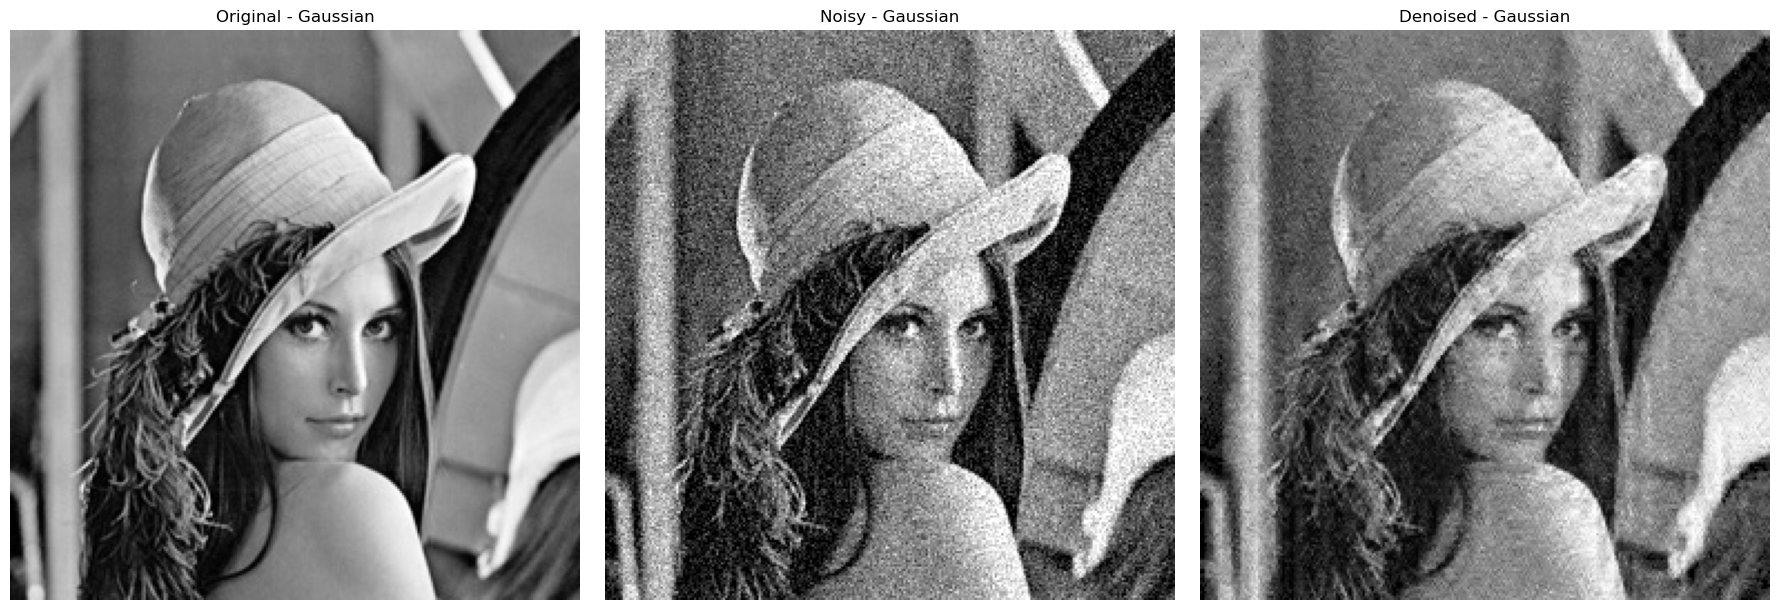


🔸 Gaussian White Noise:
  ➤ PSNR (noisy): 17.51 dB | SSIM: 0.3606
  ➤ PSNR (denoised): 20.51 dB | SSIM: 0.4423


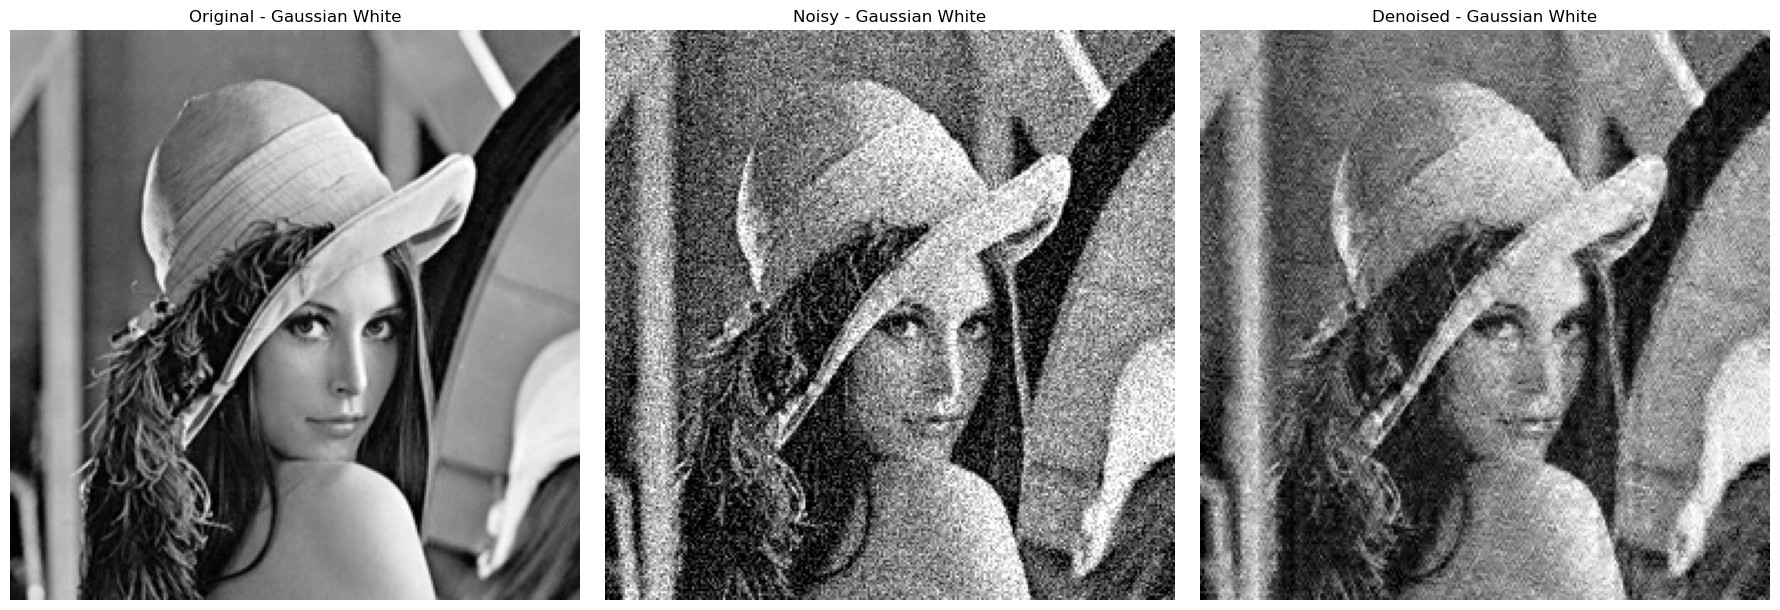


🔸 Salt & Pepper Noise:
  ➤ PSNR (noisy): 18.21 dB | SSIM: 0.4758
  ➤ PSNR (denoised): 20.44 dB | SSIM: 0.4812


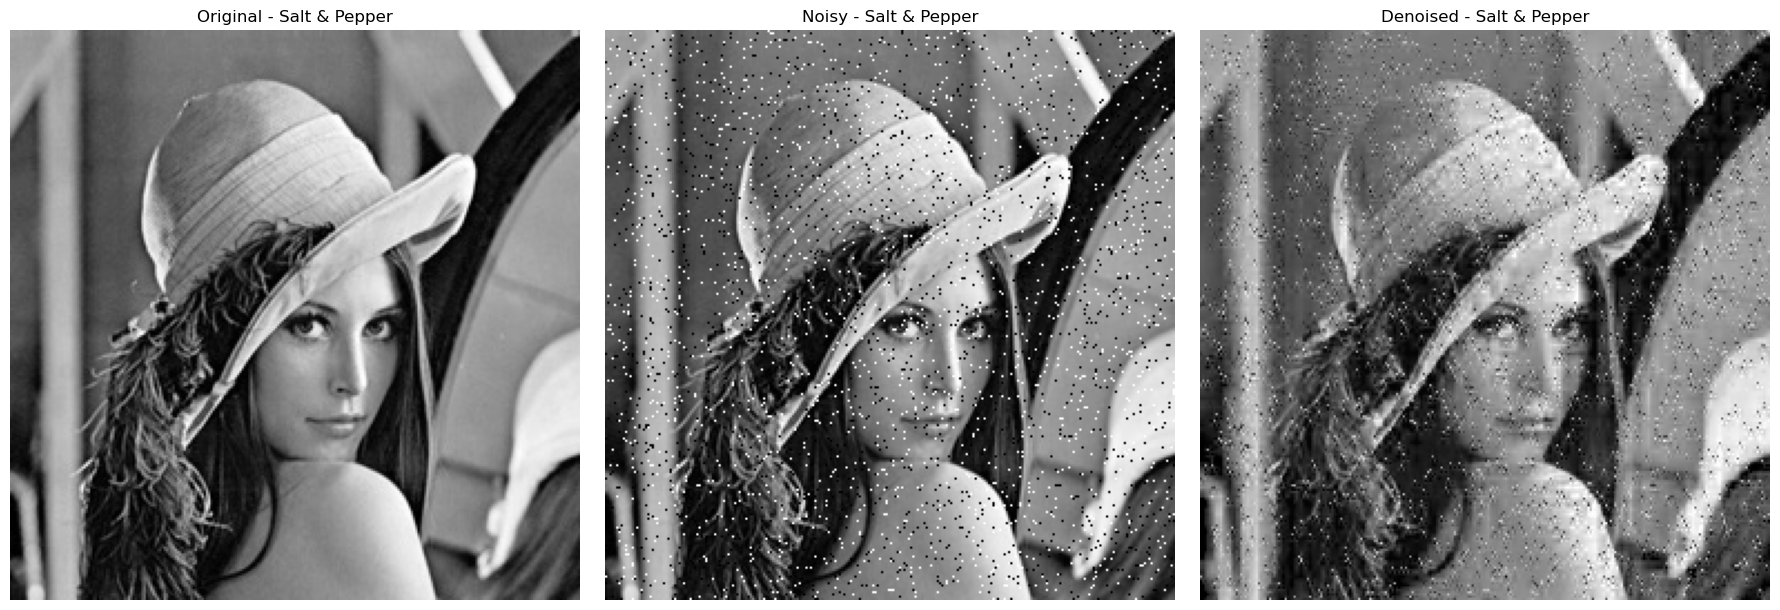

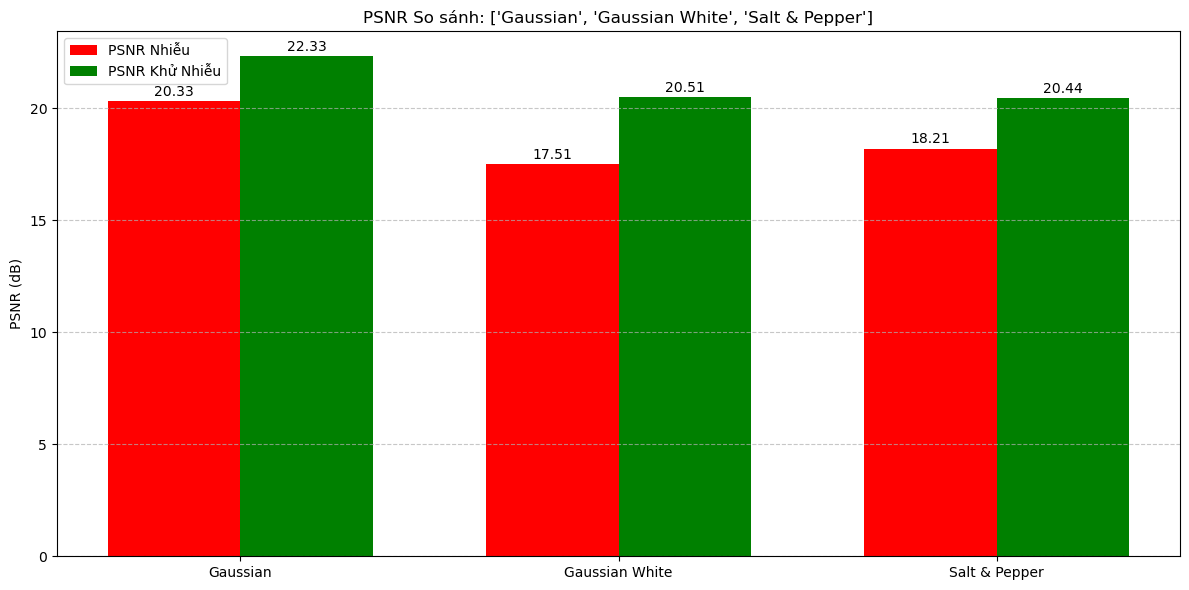

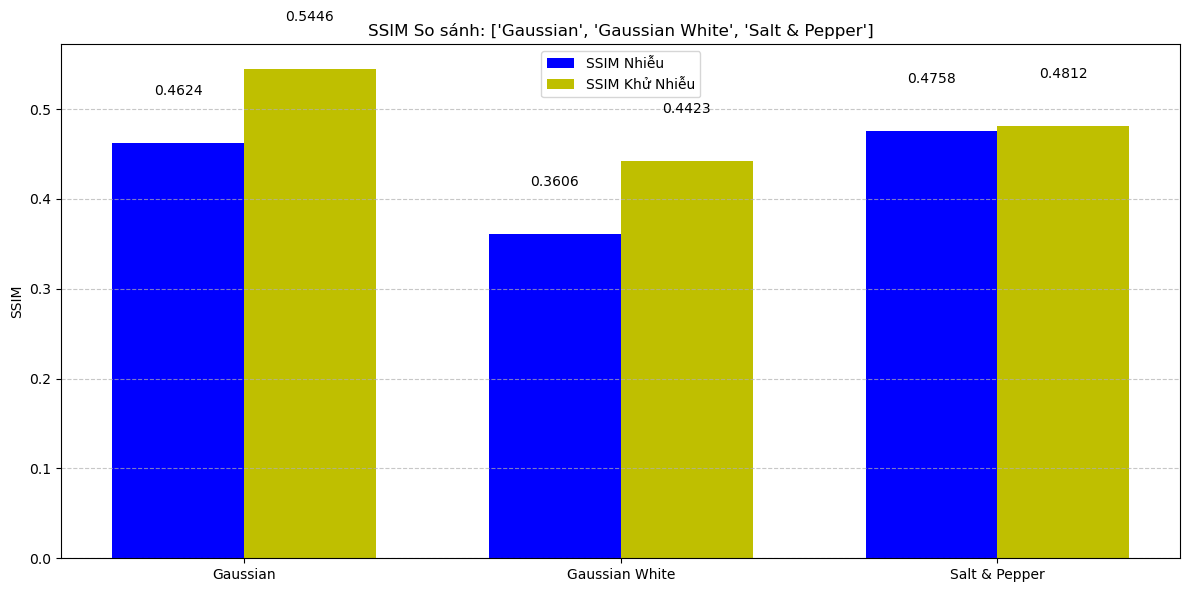

In [12]:
# === Thực thi === #
main(image_path1)


🔸 Gaussian Noise:
  ➤ PSNR (noisy): 20.31 dB | SSIM: 0.2458
  ➤ PSNR (denoised): 25.17 dB | SSIM: 0.4410


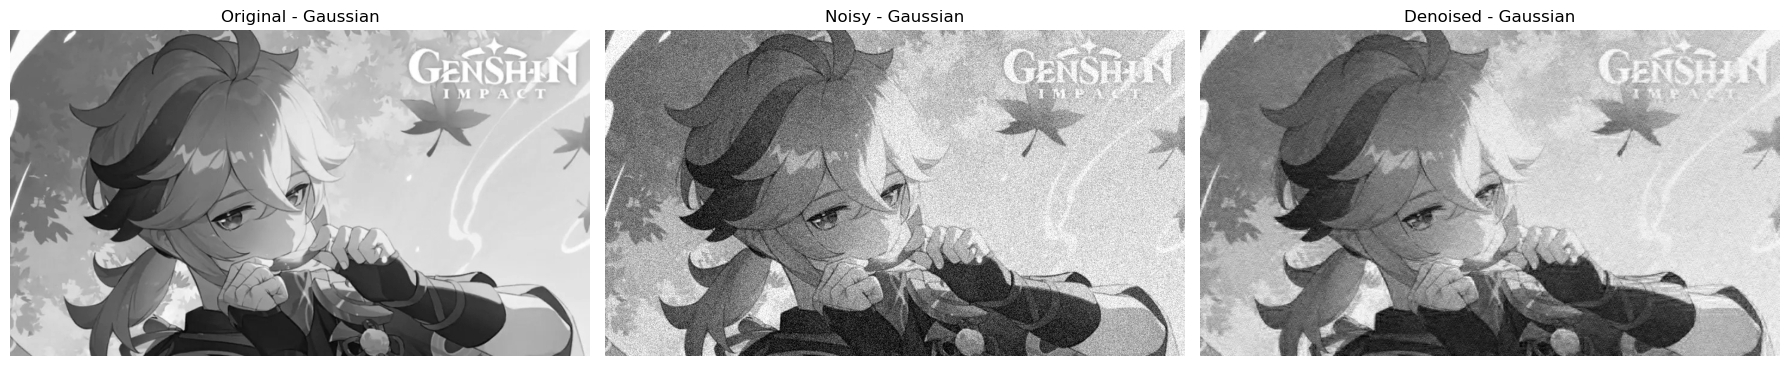


🔸 Gaussian White Noise:
  ➤ PSNR (noisy): 17.55 dB | SSIM: 0.1708
  ➤ PSNR (denoised): 22.57 dB | SSIM: 0.3135


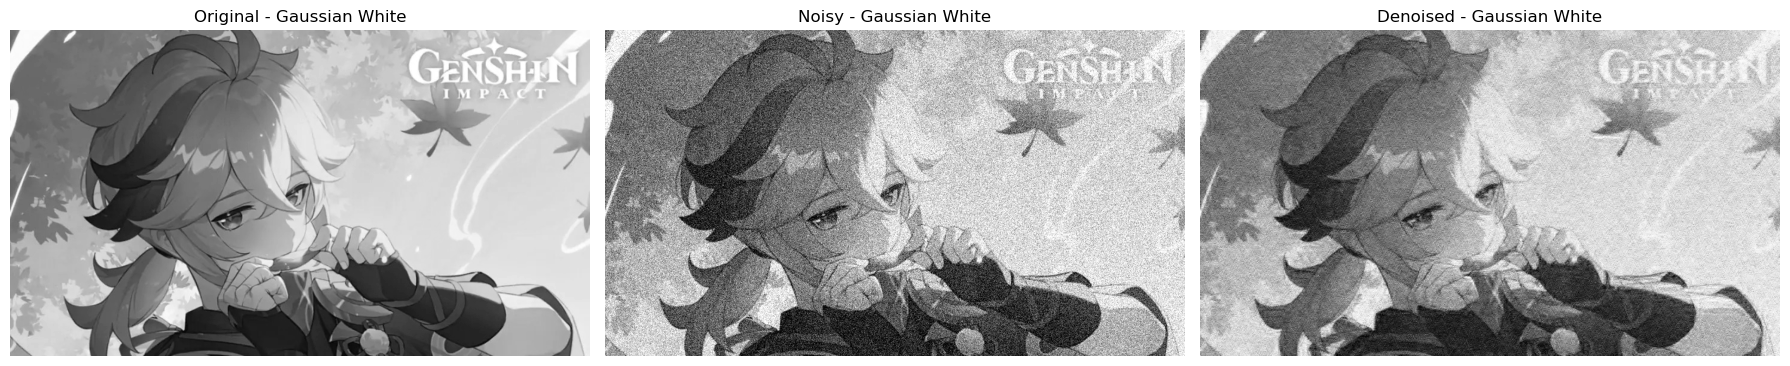


🔸 Salt & Pepper Noise:
  ➤ PSNR (noisy): 17.91 dB | SSIM: 0.3091
  ➤ PSNR (denoised): 21.80 dB | SSIM: 0.3652


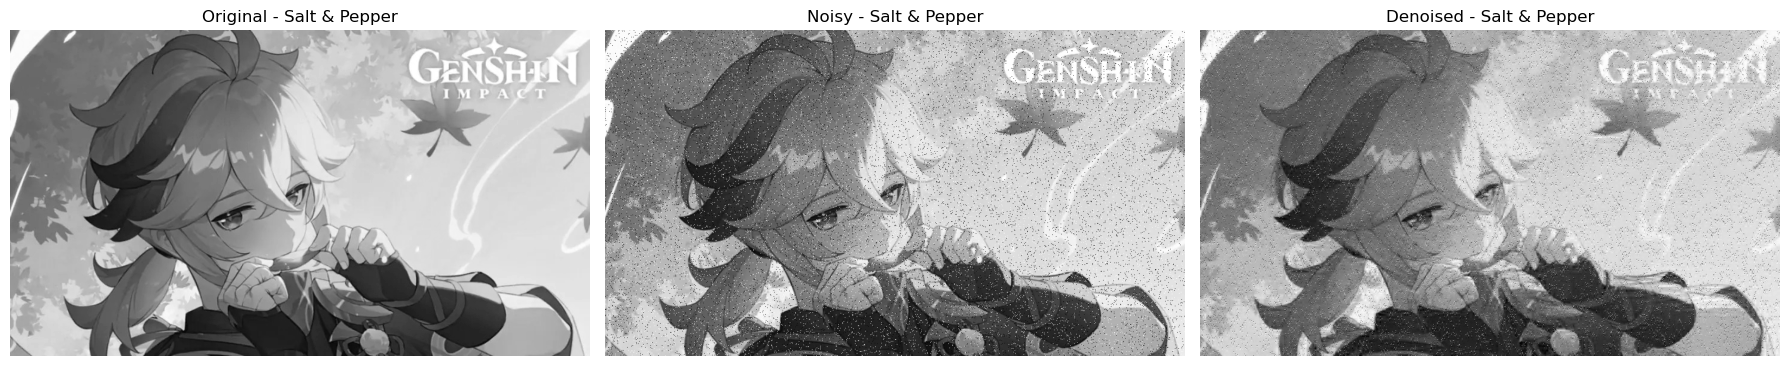

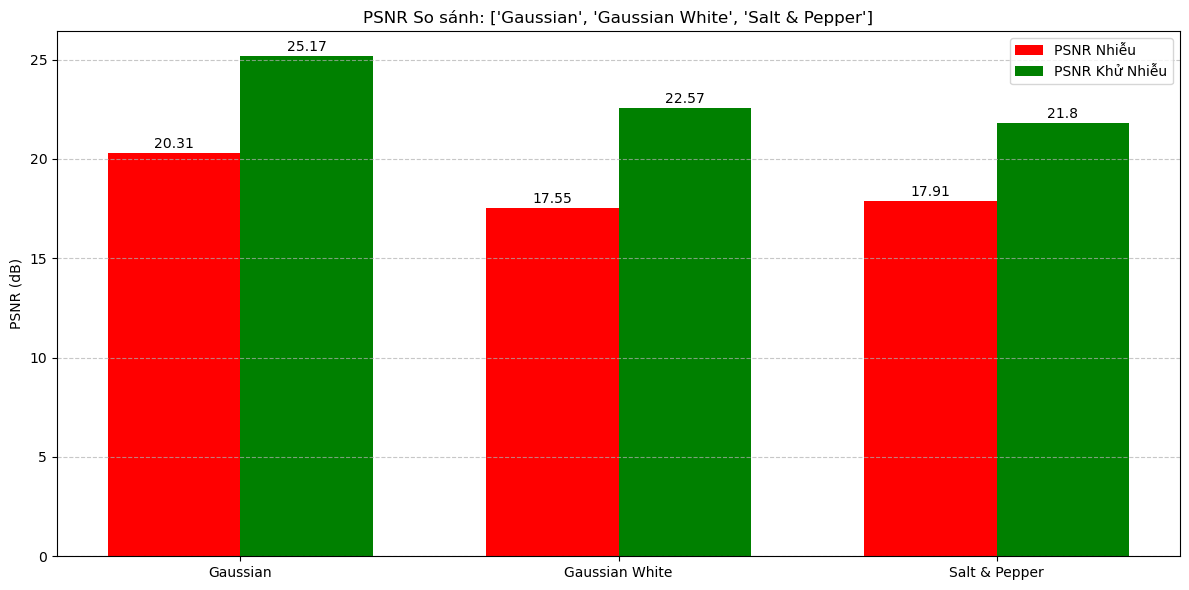

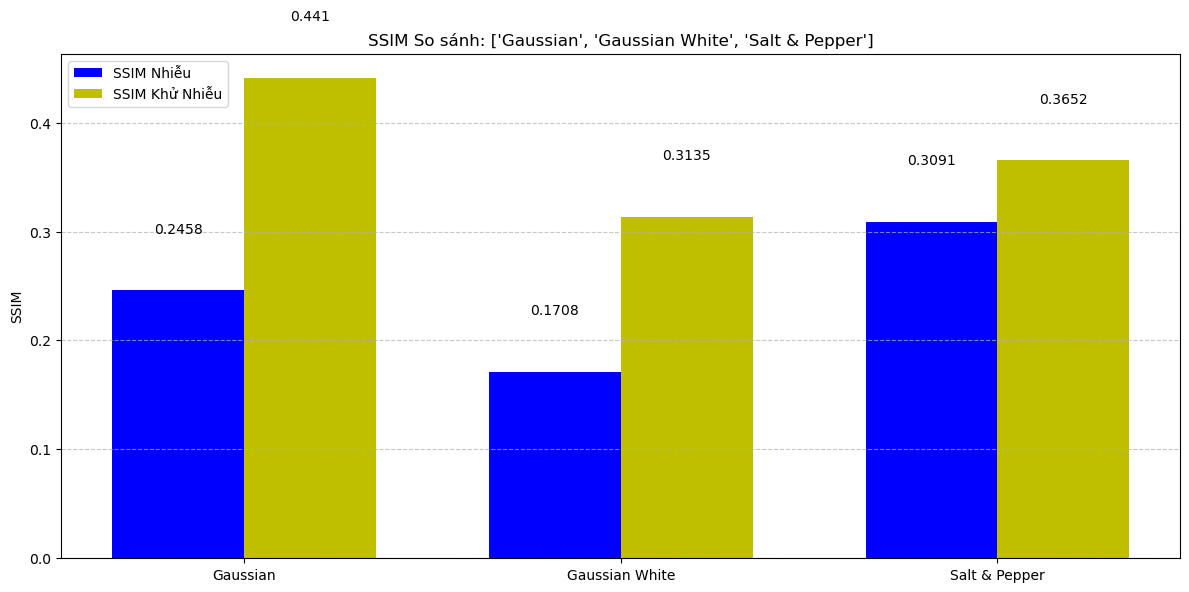

In [13]:
main(image_path2)